In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.append("/home/dchen/BA_CH_EN/")


import os

os.environ[
    "CUDA_VISIBLE_DEVICES"
] = "-1"  # this line tells TensorFlow not to use any GPU

# Basics
import tensorflow as tf
import xarray as xr
import pandas as pd

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.unet import Unet
from src.models.U_net.u_net_tests_params import *
from src.models.U_net.unet import *
from src.models.U_net.u_net_predict_evaluate import *

<IPython.core.display.Javascript object>

### 0. Set Up

In [15]:
lead_time = 0
var_num = 2
CRPS_baseline_scores_t2m = crps_load_lead_lat_lon("t2m")

land_sea_mask_dummy = np.load(
    "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
)
land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)

# load data
test_var_mean = []
test_var_std = []
test_var_y = []
for var in range(6):
    (
        padded_test_data_mean,
        padded_test_data_std,
        padded_test_data_y,
    ) = u_net_load_test_data(var, lead_time)
    test_var_mean.append(padded_test_data_mean)
    test_var_std.append(padded_test_data_std)
    test_var_y.append(padded_test_data_y)

# Then, pack all of your input data into a list
test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

test_target = test_var_y[var_num]

<IPython.core.display.Javascript object>

In [4]:
def plot_losses(csv_filepath, starting_epoch=0, ending_epoch=1000000000):
    # Load the csv file into a pandas DataFrame
    data = pd.read_csv(csv_filepath).iloc[starting_epoch:ending_epoch]

    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Plot the training loss
    plt.plot(data["epoch"], data["loss"], label="Train Loss")

    # Plot the validation loss
    plt.plot(data["epoch"], data["val_loss"], label="Validation Loss")

    # Set the labels for the x and y axes
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Set the title for the plot
    plt.title("Training and Validation Loss")

    # Enable the legend
    plt.legend()

    # Display the plot
    plt.show()
    return data

<IPython.core.display.Javascript object>

In [5]:
def test_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
            "CustomSchedule": CustomSchedule,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)
    # load data
    test_var_mean = []
    test_var_std = []
    test_var_y = []
    for var in range(6):
        (
            padded_test_data_mean,
            padded_test_data_std,
            padded_test_data_y,
        ) = u_net_load_test_data(var, lead_time)
        test_var_mean.append(padded_test_data_mean)
        test_var_std.append(padded_test_data_std)
        test_var_y.append(padded_test_data_y)

    # Then, pack all of your input data into a list
    test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

    test_target = test_var_y[var_num]
    test_target_unpad = unpad_images_y(test_target)

    preds = model.predict(test_inputs, verbose=1)
    predictions_unpad = unpad_images(preds)
    if var_num in [5]:
        crps = crps_trunc
    else:
        crps = crps_normal

    scores = crps(
        mu=predictions_unpad[:, :, :, 0].flatten(),
        sigma=predictions_unpad[:, :, :, 1].flatten(),
        y=test_target_unpad.flatten(),
    )
    scores = scores.reshape((357, 120, 130)).mean(axis=0)
    return predictions_unpad, scores


def train_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
            "CustomSchedule": CustomSchedule,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 1429, axis=0)
    # load data
    train_var_mean = []
    train_var_std = []
    train_var_y = []
    for var in range(6):
        (
            padded_train_data_mean,
            padded_train_data_std,
            padded_train_data_y,
        ) = u_net_load_train_data(var, lead_time)
        train_var_mean.append(padded_train_data_mean)
        train_var_std.append(padded_train_data_std)
        train_var_y.append(padded_train_data_y)

    # Then, pack all of your input data into a list
    train_inputs = train_var_mean + train_var_std + [land_sea_mask_dummy]

    train_target = train_var_y[var_num]
    train_target_unpad = unpad_images_y(train_target)

    preds = model.predict(train_inputs, verbose=1)
    predictions_unpad = unpad_images(preds)
    if var_num in [5]:
        crps = crps_trunc
    else:
        crps = crps_normal

    scores = crps(
        mu=predictions_unpad[:, :, :, 0].flatten(),
        sigma=predictions_unpad[:, :, :, 1].flatten(),
        y=train_target_unpad.flatten(),
    )
    scores = scores.reshape((1429, 120, 130)).mean(axis=0)
    return predictions_unpad, scores

<IPython.core.display.Javascript object>

### Run 3

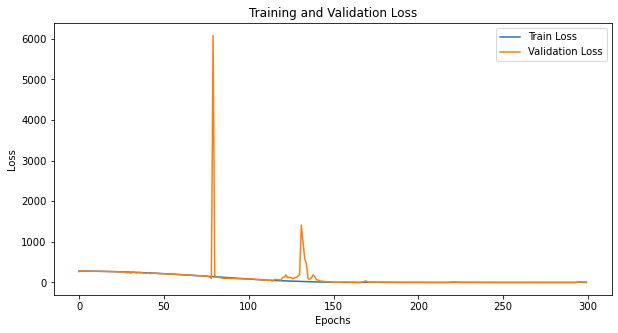

<IPython.core.display.Javascript object>

In [8]:
df_3 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.001_ep_300_bs_128_filters20.csv",
)

In [10]:
df_3

,epoch,loss,val_loss
0,0,282.352325,266.861145
1,1,281.530243,283.445312
2,2,281.099945,284.524475
3,3,280.664429,282.363922
4,4,280.218964,280.156464
...,...,...,...
295,295,4.800007,9.539442
296,296,4.106001,10.331440
297,297,3.138860,12.331377
298,298,2.202050,11.763238


<IPython.core.display.Javascript object>

### Run 4

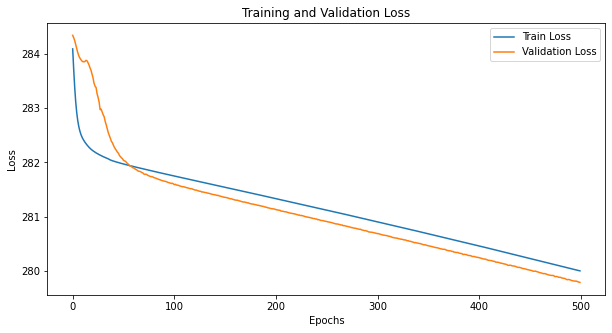

<IPython.core.display.Javascript object>

In [11]:
df_run_4 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_1e-05_ep_500_bs_128_filters20.csv"
)

In [12]:
df_run_4

,epoch,loss,val_loss
0,0,284.087891,284.337036
1,1,283.708252,284.293976
2,2,283.373230,284.239075
3,3,283.106476,284.167297
4,4,282.909271,284.089111
...,...,...,...
495,495,280.020203,279.814697
496,496,280.015594,279.807404
497,497,280.010803,279.799866
498,498,280.006073,279.794342


<IPython.core.display.Javascript object>

### Run 5

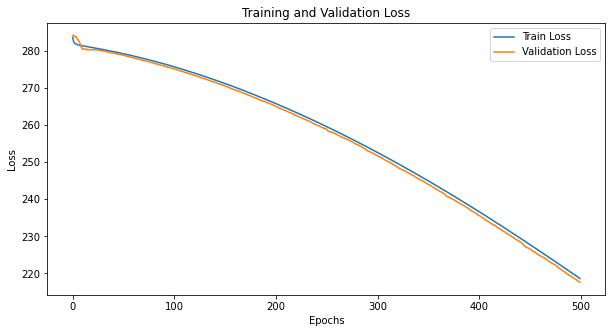

<IPython.core.display.Javascript object>

In [13]:
df_run_5 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.0001_ep_500_bs_128_filters24.csv"
)

In [14]:
df_run_5

,epoch,loss,val_loss
0,0,283.558380,284.089417
1,1,282.403137,284.142609
2,2,281.979218,283.778687
3,3,281.819305,283.861938
4,4,281.692719,283.352783
...,...,...,...
495,495,219.408401,218.469101
496,496,219.220200,218.147034
497,497,219.031815,217.960876
498,498,218.843414,217.822937


<IPython.core.display.Javascript object>

### Run 6

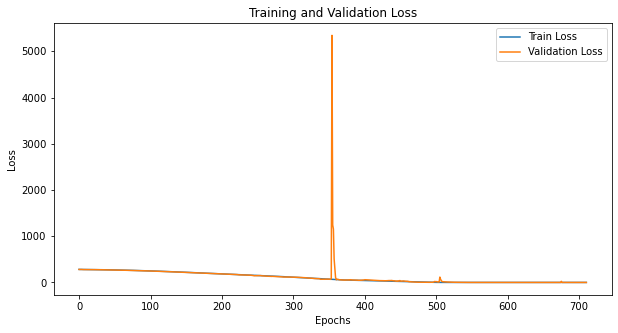

<IPython.core.display.Javascript object>

In [17]:
df_run_6_0 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.0003_ep_3000_bs_128_filters24.csv"
)

In [49]:
df_run_6_0

,epoch,loss,val_loss
0,0,282.536072,281.936432
1,1,281.727844,280.160065
2,2,281.557953,282.133759
3,3,281.402832,281.851379
4,4,281.249878,280.122223
...,...,...,...
706,706,0.447527,0.470535
707,707,0.443581,0.670311
708,708,0.446021,0.562746
709,709,0.479353,0.633561


<IPython.core.display.Javascript object>

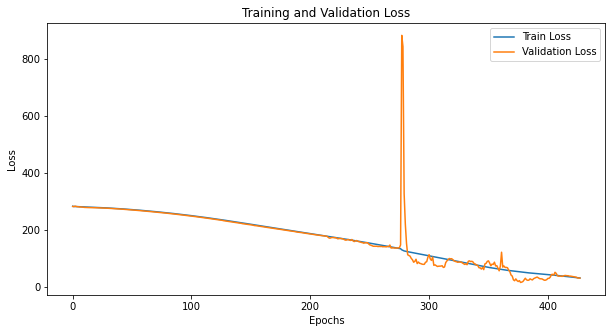

<IPython.core.display.Javascript object>

In [19]:
df_run_6_15 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_15_lr_0.0003_ep_3000_bs_128_filters24.csv"
)

In [20]:
df_run_6_15

,epoch,loss,val_loss
0,0,282.491364,281.698151
1,1,281.657257,281.059479
2,2,281.486053,282.844116
3,3,281.323212,281.627350
4,4,281.162903,280.849060
...,...,...,...
423,423,32.735935,34.432526
424,424,32.269897,33.568707
425,425,31.823380,30.889746
426,426,31.360958,30.874193


<IPython.core.display.Javascript object>

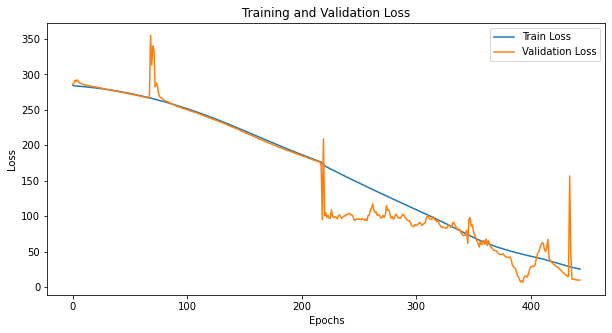

<IPython.core.display.Javascript object>

In [28]:
df_run_6_30 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_30_lr_0.0003_ep_3000_bs_128_filters24.csv"
)

In [29]:
df_run_6_30

,epoch,loss,val_loss
0,0,284.888672,286.238251
1,1,284.046722,287.385345
2,2,283.816833,291.813721
3,3,283.637360,290.055878
4,4,283.483398,292.225586
...,...,...,...
439,439,26.896139,10.530169
440,440,26.509995,10.177122
441,441,26.114508,10.103909
442,442,25.741030,10.042186


<IPython.core.display.Javascript object>

In [37]:
df_run_6_30["val_loss"].idxmin()

393

<IPython.core.display.Javascript object>

In [39]:
df_run_6_30.iloc[df_run_6_30["val_loss"].idxmin()]

epoch       393.000000
loss         46.277405
val_loss      6.602448
Name: 393, dtype: float64

<IPython.core.display.Javascript object>

### Run 7

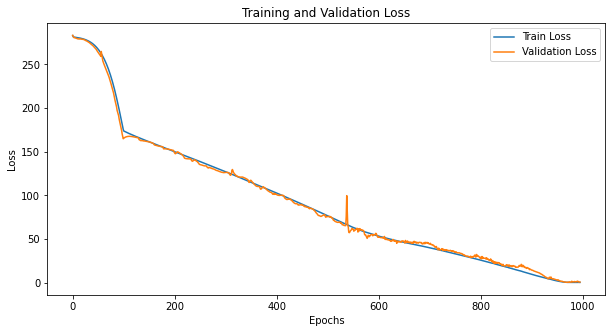

<IPython.core.display.Javascript object>

In [35]:
df_run_7_0 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.001_ep_3000_bs_128_filters24.csv",
)

In [64]:
df_run_7_0

,epoch,loss,val_loss
0,0,282.875580,283.135101
1,1,281.473022,281.914154
2,2,281.246735,281.092102
3,3,281.131012,280.344025
4,4,281.041351,280.479706
...,...,...,...
990,990,0.592447,1.801570
991,991,0.553557,0.976763
992,992,0.469954,1.100855
993,993,0.467218,1.052129


<IPython.core.display.Javascript object>

In [8]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_0_lr_0.001_ep_3000_bs_128_filters24.h5",
    2,
    0,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

2023-07-07 11:07:34.080671: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-07 11:07:34.080732: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: econ-stat-RR02
2023-07-07 11:07:34.080744: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: econ-stat-RR02
2023-07-07 11:07:34.080942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-07-07 11:07:34.080983: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.60.2
2023-07-07 11:07:34.080994: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.60.2 does not match DSO version 525.125.6 -- cannot find working devices in this configuration
2023-07-07 11:07:34.081371: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with on

12/12 [==============================] - 23s 2s/step


<IPython.core.display.Javascript object>

Number of Nan Values: 0
Number of inf Values: 0


0.5918716799968116

<IPython.core.display.Javascript object>

In [10]:
train_preds, train_scores = train_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_0_lr_0.001_ep_3000_bs_128_filters24.h5",
    2,
    0,
)

print(f"Number of Nan Values: {np.isnan(train_scores).sum()}")
print(f"Number of inf Values: {np.isinf(train_scores).sum()}")
trainting = train_scores[~np.isnan(train_scores)]
trainting = trainting[~np.isinf(trainting)]
trainting.mean()

45/45 [==============================] - 90s 2s/step


<IPython.core.display.Javascript object>

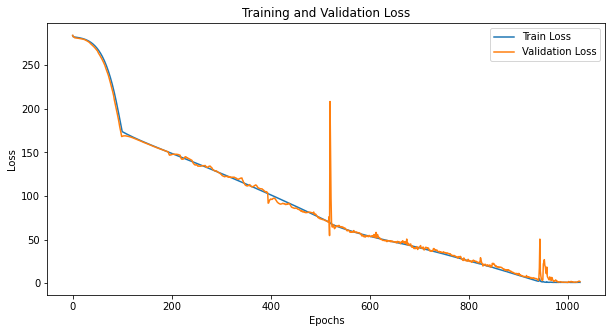

<IPython.core.display.Javascript object>

In [12]:
df_run_7_15 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_15_lr_0.001_ep_3000_bs_128_filters24.csv",
)

In [20]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_15_lr_0.001_ep_3000_bs_128_filters24.h5",
    2,
    15,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 22s 2s/step
Number of Nan Values: 0
Number of inf Values: 0


0.8892529435868155

<IPython.core.display.Javascript object>

In [21]:
train_preds, train_scores = train_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_15_lr_0.001_ep_3000_bs_128_filters24.h5",
    2,
    15,
)

print(f"Number of Nan Values: {np.isnan(train_scores).sum()}")
print(f"Number of inf Values: {np.isinf(train_scores).sum()}")
trainting = train_scores[~np.isnan(train_scores)]
trainting = trainting[~np.isinf(trainting)]
trainting.mean()

45/45 [==============================] - 90s 2s/step
Number of Nan Values: 0
Number of inf Values: 0


0.8856693059278462

<IPython.core.display.Javascript object>

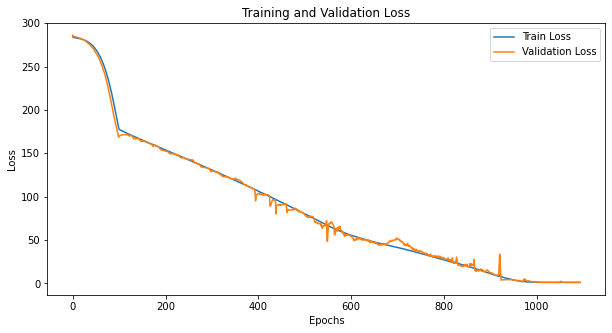

<IPython.core.display.Javascript object>

In [65]:
df_run_7_30 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_30_lr_0.001_ep_3000_bs_128_filters24.csv",
)

In [66]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_30_lr_0.001_ep_3000_bs_128_filters24.h5",
    2,
    30,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 22s 2s/step
Number of Nan Values: 0
Number of inf Values: 0


1.251979618276477

<IPython.core.display.Javascript object>

In [23]:
train_preds, train_scores = train_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_30_lr_0.001_ep_3000_bs_128_filters24.h5",
    2,
    30,
)

print(f"Number of Nan Values: {np.isnan(train_scores).sum()}")
print(f"Number of inf Values: {np.isinf(train_scores).sum()}")
trainting = train_scores[~np.isnan(train_scores)]
trainting = trainting[~np.isinf(trainting)]
trainting.mean()

45/45 [==============================] - 87s 2s/step
Number of Nan Values: 0
Number of inf Values: 0


1.1749505481155704

<IPython.core.display.Javascript object>

### Run 8:

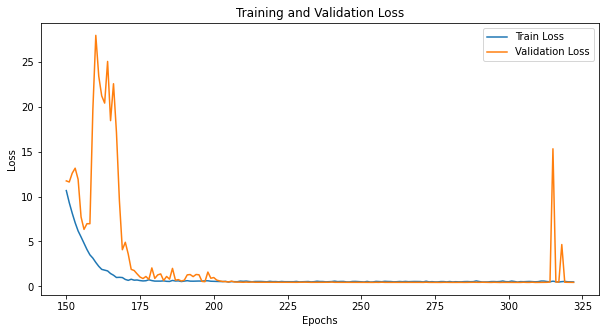

<IPython.core.display.Javascript object>

In [6]:
df_run_8_0 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.001_ep_3000_bs_64_filters24.csv",
    150,
)

In [7]:
df_run_8_0

,epoch,loss,val_loss
150,150,10.658091,11.736961
151,151,9.313472,11.612703
152,152,8.146349,12.591621
153,153,7.079764,13.151006
154,154,6.167963,11.909662
...,...,...,...
318,318,0.526160,4.655961
319,319,0.548426,0.458770
320,320,0.514831,0.449325
321,321,0.505163,0.442453


<IPython.core.display.Javascript object>

In [8]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_0_lr_0.001_ep_3000_bs_64_filters24.h5",
    2,
    0,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

2023-07-07 15:27:07.384807: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-07 15:27:07.384865: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: econ-stat-RR02
2023-07-07 15:27:07.384878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: econ-stat-RR02
2023-07-07 15:27:07.385037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-07-07 15:27:07.385077: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.60.2
2023-07-07 15:27:07.385089: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.60.2 does not match DSO version 525.125.6 -- cannot find working devices in this configuration
2023-07-07 15:27:07.385880: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with on

12/12 [==============================] - 23s 2s/step
Number of Nan Values: 0
Number of inf Values: 0


0.41582286278541536

<IPython.core.display.Javascript object>

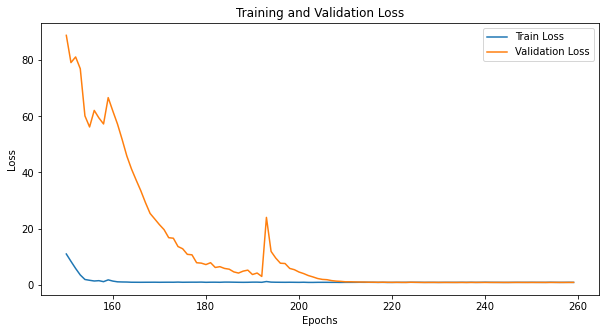

<IPython.core.display.Javascript object>

In [9]:
df_run_8_15 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_15_lr_0.001_ep_3000_bs_64_filters24.csv",
    150,
)

In [10]:
df_run_8_15

,epoch,loss,val_loss
150,150,10.928832,88.884239
151,151,8.306248,79.175995
152,152,5.770347,81.190720
153,153,3.448895,76.989983
154,154,1.843409,60.170532
...,...,...,...
255,255,0.815805,0.802728
256,256,0.804405,0.791873
257,257,0.812883,0.788048
258,258,0.829976,0.789542


<IPython.core.display.Javascript object>

In [11]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_15_lr_0.001_ep_3000_bs_64_filters24.h5",
    2,
    15,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 22s 2s/step
Number of Nan Values: 0
Number of inf Values: 0


0.8039590312958986

<IPython.core.display.Javascript object>

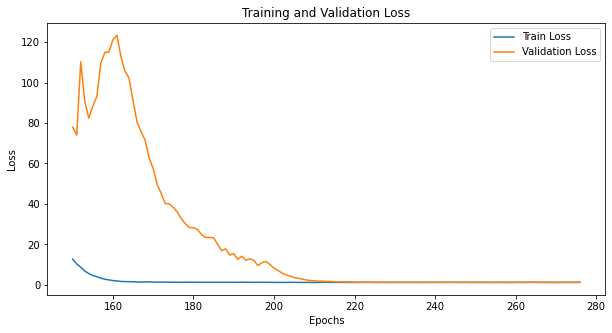

<IPython.core.display.Javascript object>

In [12]:
df_run_8_30 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_30_lr_0.001_ep_3000_bs_64_filters24.csv",
    150,
)

In [13]:
df_run_8_30

,epoch,loss,val_loss
150,150,12.752333,77.935478
151,151,10.292153,73.969971
152,152,8.690390,110.231934
153,153,6.798268,90.616798
154,154,5.546212,82.406990
...,...,...,...
272,272,1.188473,1.237646
273,273,1.197602,1.191016
274,274,1.182931,1.245762
275,275,1.175916,1.262326


<IPython.core.display.Javascript object>

In [14]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_30_lr_0.001_ep_3000_bs_64_filters24.h5",
    2,
    30,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 22s 2s/step
Number of Nan Values: 0
Number of inf Values: 0


1.2238453334285788

<IPython.core.display.Javascript object>

In [18]:
CRPS_baseline_scores_t2m[0].mean()

0.5084816639136492

<IPython.core.display.Javascript object>